Compare the magnitudes produced by tractor to the magnitudes produced by the curve of growth

In [1]:
from glob import glob
import os, sys
import astropy
from astropy.table import Table
import fitsio
import numpy as np

In [2]:
path = '/global/homes/m/mkwiecie/desi/sv3-clustering'
output_path = '/global/cscratch1/sd/mkwiecie/legacydata/output/3962/'
base_cat = 'BGS_BRIGHT_S_clustering.dat.fits'

In [3]:
finished_galaxy_paths = glob(output_path+'*', recursive=True)

In [4]:
def _read_ccds_tractor_sample(galaxy_dir, galaxy, prefix="custom"):
    nccds, tractor, sample = None, None, None
    refcolumn='TARGETID'

    # samplefile can exist without tractorfile when using --just-coadds
    samplefile = os.path.join(galaxy_dir, "{}-sample.fits".format(galaxy))
    if os.path.isfile(samplefile):
        sample = astropy.table.Table(fitsio.read(samplefile, upper=True))

    tractorfile = os.path.join(
        galaxy_dir, "{}-{}-tractor.fits".format(galaxy, prefix)
    )
    if os.path.isfile(tractorfile):
        cols = [
            "ref_cat",
            "ref_id",
            "type",
            "sersic",
            "shape_r",
            "shape_e1",
            "shape_e2",
            "flux_g",
            "flux_r",
            "flux_z",
            "flux_ivar_g",
            "flux_ivar_r",
            "flux_ivar_z",
        ]
        tractor = astropy.table.Table(
            fitsio.read(tractorfile, lower=True, columns=cols)
        )  
        
        wt, ws = [], []
        for ii, sid in enumerate(sample[refcolumn]):
            ww = np.where(tractor["ref_id"] == sid)[0]
            if len(ww) > 0:
                wt.append(ww)
                ws.append(ii)
        if len(wt) == 0:
            tractor = None
        else:
            wt = np.hstack(wt)
            ws = np.hstack(ws)
            tractor = tractor[wt]
            sample = sample[ws]
            srt = np.argsort(tractor["flux_r"])[::-1]
            tractor = tractor[srt]
            sample = sample[srt]
            assert np.all(tractor["ref_id"] == sample[refcolumn])
    return tractor, sample

In [9]:
def _get_mags(
    cat,
    rad="10",
    bands=["g", "r", "z"],
    kpc=False,
    pipeline=False,
    cog=False,
    R24=False,
    R25=False,
    R26=False,
):
    res = []
    for band in bands:
        mag = None
        ff = 0
        if kpc:
            iv = cat["FLUX{}_IVAR_{}".format(rad, band.upper())][0]
            ff = cat["FLUX{}_{}".format(rad, band.upper())][0]
        elif pipeline:
            iv = cat["flux_ivar_{}".format(band.lower())]
            ff = cat["flux_{}".format(band.lower())]
        elif R24:
            mag = cat["{}_mag_sb24".format(band.lower())]
        elif R25:
            mag = cat["{}_mag_sb25".format(band.lower())]
        elif R26:
            mag = cat["{}_mag_sb26".format(band.lower())]
        elif cog:
            mag = cat["cog_mtot_{}".format(band.lower())]
        else:
            print("Thar be rocks ahead!")
        if mag:
            res.append("{:.3f}".format(mag))
        else:
            if ff > 0:
                mag = 22.5 - 2.5 * np.log10(ff)
                if iv > 0:
                    ee = 1 / np.sqrt(iv)
                    magerr = 2.5 * ee / ff / np.log(10)
                res.append("{:.3f}".format(mag))
            elif ff < 0 and iv > 0:
                # upper limit
                mag = 22.5 - 2.5 * np.log10(1 / np.sqrt(iv))
                res.append(">{:.3f}".format(mag))
            else:
                res.append(0) #Nan?
    return res

In [10]:
def read_ellipsefit(galaxy, galaxydir, filesuffix='', galaxy_id='', verbose=True,
                    asTable=False):
    """Read the output of write_ellipsefit. Convert the astropy Table into a
    dictionary so we can use a bunch of legacy code.

    """
    if galaxy_id.strip() == '':
        galid = ''
    else:
        galid = '-{}'.format(galaxy_id)
    if filesuffix.strip() == '':
        fsuff = ''
    else:
        fsuff = '-{}'.format(filesuffix)

    ellipsefitfile = os.path.join(galaxydir, '{}{}-ellipse{}.fits'.format(galaxy, fsuff, galid))
        
    if os.path.isfile(ellipsefitfile):
        data = Table(fitsio.read(ellipsefitfile))

        # Optionally convert (back!) into a dictionary.
        if asTable:
            return data
        ellipsefit = {}
        for key in data.colnames:
            val = data[key][0]
            ellipsefit[key.lower()] = val # lowercase!
    else:
        if verbose:
            print('File {} not found!'.format(ellipsefitfile))
        if asTable:
            ellipsefit = Table()
        else:
            ellipsefit = dict()

    return ellipsefit

In [11]:
flux_r_dered = []
# flux_g_dered = []
# flux_z_dered = []

tractor_mag_r = []
# tractor_mag_g = []
# tractor_mag_z = []

cog_mag_r = []
# cog_mag_g = []
# cog_mag_z = []

z = []
ra = []
dec = []
weight = []
radius_mosaic = []
target_id = []

for path in finished_galaxy_paths:
    galaxydir = path
    galaxy = path.split("/")[-1]
    
    tractor, sample = _read_ccds_tractor_sample(galaxydir, galaxy, prefix="custom")
    if tractor is None:
        continue

    for tt, ss in zip(tractor, sample):
        g_tractor, r_tractor, z_tractor = _get_mags(tt, pipeline=True)

        if r_tractor is None:
            continue

        galaxyid = str(tt["ref_id"])
        ellipse = read_ellipsefit(
            galaxy,
            galaxydir,
            filesuffix="custom",
            galaxy_id=galaxyid,
            verbose=False,
        )
        if bool(ellipse):
            g_COG, r_COG, z_COG = _get_mags(ellipse, cog=True)



        flux_r_dered.append(sample['FLUX_R_DERED'][0])
        # flux_g_dered.append(sample['FLUX_G_DERED'])
        # flux_z_dered.append(sample['FLUX_Z_DERED'])
        z.append(sample['Z'])
        radius_mosaic.append(sample['RADIUS_MOSAIC'])
        ra.append(sample['RA'])
        dec.append(sample['DEC'])

        tractor_mag_r.append(r_tractor)
        cog_mag_r.append(r_COG)
        # tractor_mag_g.append(g_tractor)
        # cog_mag_g.append(g_COG)
        # tractor_mag_z.append(z_tractor)
        # cog_mag_z.append(z_COG)
        weight.append(sample['WEIGHT'])
        target_id.append(sample['TARGETID'])

In [12]:
flux_r_dered = np.array(flux_r_dered, dtype=np.float64)
# flux_g_dered = np.array(flux_g_dered, dtype=np.float64)
# flux_z_dered = np.array(flux_z_dered, dtype=np.float64)
tractor_mag_r = np.array(tractor_mag_r, dtype=np.float64)
cog_mag_r = np.array(cog_mag_r, dtype=np.float64)
# tractor_mag_g = np.array(tractor_mag_g, dtype=np.float64)
# cog_mag_g = np.array(cog_mag_g, dtype=np.float64)
# tractor_mag_z = np.array(tractor_mag_z, dtype=np.float64)
# cog_mag_z = np.array(cog_mag_z, dtype=np.float64)

z = np.array(z, dtype=np.float64)
radius_mosaic = np.array(radius_mosaic, dtype=np.float64)
ra = np.array(ra, dtype=np.float64)
dec = np.array(dec, dtype=np.float64)
weight = np.array(weight, dtype=np.float64)

In [13]:
mag_bins = [12.06, 12.804, 13.548, 14.292, 15.036, 15.78, 16.524, 17.268, 18.012, 18.756, 19.49992683]
flux_bins = [14996.84835502,7557.8801368,3808.90376498,1919.55252376,967.38644997,487.5284901,245.69708276,123.8226231,62.40221421,31.44850465,15.84893192]

def flux_to_mag(flux):
    return (-5/2)*np.log10(flux) + 22.5

def mag_to_flux(mag):
    return 10**((2/5)* (22.5 - mag))

In [14]:
delta_mag_r = cog_mag_r - tractor_mag_r
print(delta_mag_r)
print(flux_r_dered)
# delta_mag_z = cog_mag_z - tractor_mag_z
# delta_mag_g = cog_mag_g - tractor_mag_g

# print(len(delta_mag_g), len(delta_mag_r), len(delta_mag_z))
# Negative means better!

[-0.212 -0.08  -0.055 ... -0.116 -0.557 -0.598]
[  21.235075     16.3192215  1275.76428223 ...  139.44848633   17.40938568
 1044.95544434]


(-3.0, 1.0)

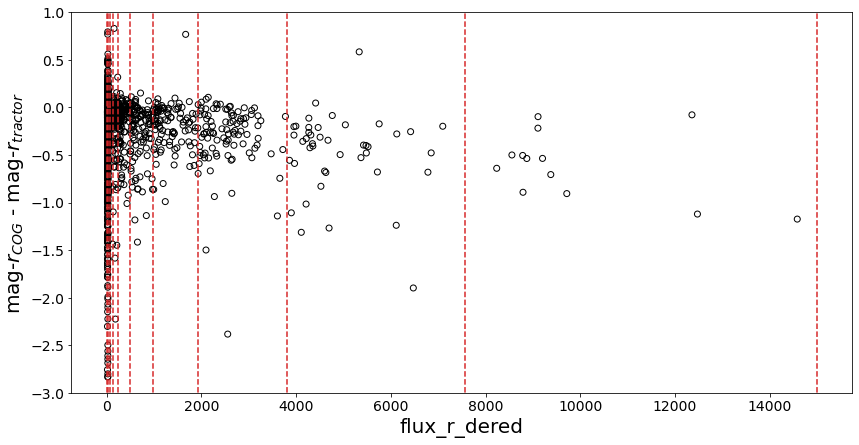

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))

plt.scatter(flux_r_dered, delta_mag_r, marker='o', lw=1, facecolor='none', edgecolor='k')
plt.hlines(0, 0, 100, ls='dashed', color='tab:red')
plt.xlabel('flux_r_dered', fontsize=20)
plt.ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
plt.vlines(flux_bins, -4, 4, ls='dashed', color='tab:red')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-3,1)

(11.5, 20.0)

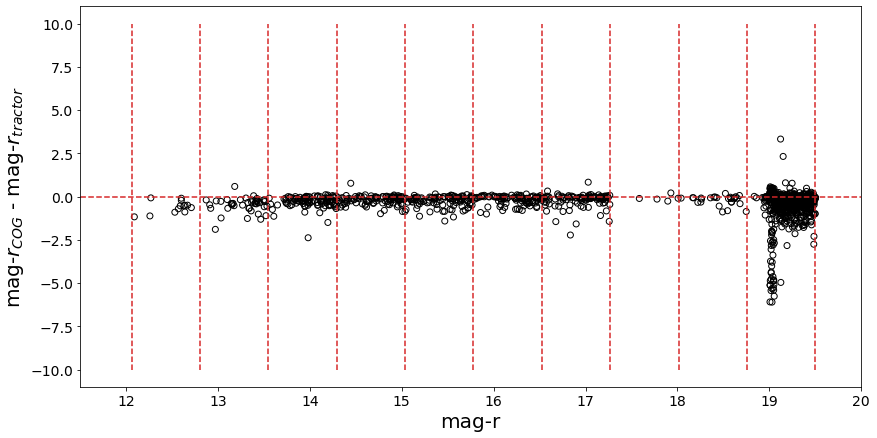

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))

plt.scatter(flux_to_mag(flux_r_dered), delta_mag_r, marker='o', lw=1, facecolor='none', edgecolor='k')
plt.hlines(0, 0, 100, ls='dashed', color='tab:red')
plt.vlines(mag_bins, -10, 10, ls='dashed', color='tab:red')
plt.xlabel('mag-r', fontsize=20)
plt.ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.ylim(-3,1)
plt.xlim(11.5, 20)

In [17]:
mag_r = flux_to_mag(flux_r_dered)

mean = []
std = []
mid_pt = []
binned_sample = []
for i in range(len(mag_bins)-1):
    this_bin_low = mag_r > mag_bins[i]
    this_bin_max = mag_r <= mag_bins[i+1]
    
    mask = np.all([this_bin_low.flatten(), this_bin_max.flatten()], axis=0)
    this_bin = delta_mag_r[mask]
    binned_sample.append(this_bin)
    mean.append(np.mean(this_bin))
    std.append(np.std(this_bin))
    mid_pt.append((mag_bins[i+1]+  mag_bins[i])/2)

In [18]:
print(len(mid_pt))
print(len(mean))

10
10


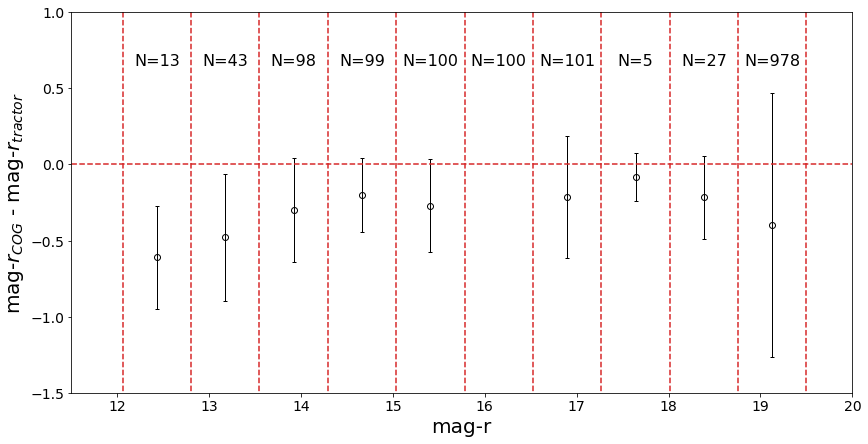

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))

plt.errorbar(mid_pt, mean, std, marker='o', lw=1, c='k', linestyle='none', 
    capsize=2, markeredgecolor='k', markerfacecolor='none', ecolor='k')
plt.hlines(0, 0, 100, ls='dashed', color='tab:red')
plt.vlines(mag_bins, -10, 10, ls='dashed', color='tab:red')
plt.xlabel('mag-r', fontsize=20)
plt.ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-1.5,1)
plt.xlim(11.5, 20)
for i in range(len(binned_sample)):
    n = len(binned_sample[i])
    mid_pt[i]
    plt.annotate(f'N={n}', xy=(mid_pt[i], 0.65), xycoords='data', horizontalalignment='center', fontsize=16)

In [ ]:
print(cog_mag_r)

[19.161 19.462 19.462 ... 18.668 18.893 18.893]
